In [1]:
DATAPATH = '../data/'
XFERPATH = '~/downloads/'  # To transfer files from Google Colab
FNAME = 'embeds_agg.csv'

In [2]:
frompath = XFERPATH + FNAME
topath = DATAPATH + FNAME
!cp $frompath $topath

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import gender_guesser.detector as gender
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from utils import get_rows, balance, balanced_split_by_time_and_id

In [4]:
df = pd.read_csv(DATAPATH+FNAME,index_col=[0,1],parse_dates=['time']).drop(['text'],axis=1)
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
425472153,2019-05-25 20:24:48+00:00,Queen K,False,9156,-31075,-21194,41023,33810
1081873499621273601,2019-05-25 20:24:48+00:00,Alexandru Constantin,True,-34055,62140,-33476,1849,42774
987721418,2019-05-25 20:24:48+00:00,Susie Carmichael,False,-38618,12734,6150,6856,29976
980758839770451973,2019-05-25 20:24:52+00:00,Princess Sih.,False,-19252,-1482,-14205,-25178,-47939
838620336367218692,2019-05-25 20:24:53+00:00,Reid Kisselback,True,-40698,32644,3243,-35412,61766


In [5]:
print(df.shape)
df.index.get_level_values(1).min(), df.index.get_level_values(1).max()

(29678, 514)


(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [6]:
xy_train, xy_valid, xy_test = balanced_split_by_time_and_id(df)

X_train = xy_train.drop(['name','male'],axis=1).values / 1e6
y_train = 1*xy_train.male.values

X_valid = xy_valid.drop(['name','male'],axis=1).values / 1e6
y_valid = 1*xy_valid.male.values

X_test = xy_test.drop(['name','male'],axis=1).values / 1e6
y_test = 1*xy_test.male.values

In [7]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_) 

[0.06617814 0.04185153 0.02776238 0.0250321  0.02302092 0.02204792
 0.02121207 0.01935231 0.01814371 0.01740349 0.01651333 0.01546586
 0.01518258 0.01496722 0.01415051 0.0137926  0.01365105 0.01320401
 0.01297017 0.01280166 0.01199954 0.01167379 0.01158718 0.01104929
 0.01079567 0.01038352 0.01028225 0.00996152 0.00982437 0.00939181
 0.00929769 0.00905794 0.00875762 0.00873787 0.00849311 0.0084166
 0.00828947 0.00810313 0.00796313 0.00784121 0.00769192 0.00762465
 0.00748959 0.00730796 0.00713632 0.00708932 0.0068693  0.00682599
 0.00674288 0.00654368 0.00649569 0.00634819 0.00625939 0.0061349
 0.00606993 0.0058607  0.00583465 0.00576193 0.00563439 0.00557769
 0.00537556 0.00520635 0.00510163 0.0050073 ]


In [8]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.5))])
model = model.fit(X_train, y_train)

/Users/andy/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
y_train_pred = model.predict_proba(X_train)[:,1]
f1_score(y_train, y_train_pred>.5)

0.6349206349206349

In [10]:
y_pred = model.predict_proba(X_valid)[:,1]
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[1291  872]
 [ 809 1354]]


0.6169970380496697

In [11]:
y_test_pred = model.predict_proba(X_test)[:,1]
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[1290  791]
 [ 811 1270]]


0.61323032351521

In [12]:
accuracy_score(y_test, y_test_pred>.5)

0.6150888995675157

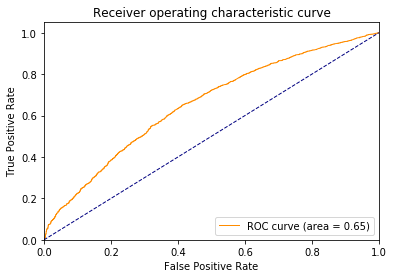

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()